In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

#1. Data Collection and Pre-processing
# Load data (replace with your actual file names)
df = pd.read_csv('BASAL ALL.csv')

# Creating a DataFrame from the numpy array #splitting the dataset
X = df.drop(columns=['SPAD'])  # Drop 'sample_id' and 'SPAD' to get the features
y = df['SPAD']  # Target variable

# Check for missing values
print(df.isnull().sum())


500.075    0
500.336    0
500.597    0
500.858    0
501.119    0
          ..
950.048    0
950.286    0
950.524    0
950.763    0
SPAD       0
Length: 1793, dtype: int64


In [2]:
#Explore data statistics
df.describe()

500.075    500.336    500.597    500.858    501.119    501.381  \
count  81.000000  81.000000  81.000000  81.000000  81.000000  81.000000   
mean    6.027284   6.382771   6.683498   6.713717   6.313813   6.360933   
std     2.473282   2.672697   2.874312   2.853133   2.662962   2.756672   
min     2.690000   2.723333   2.723333   2.870000   2.720000   2.673333   
25%     3.843333   3.986667   4.223333   4.376667   4.120000   4.013333   
50%     6.001111   5.998889   6.046667   6.283333   5.860000   5.810000   
75%     7.846667   7.956667   8.270000   8.093333   7.776667   7.880000   
max    12.201111  13.646667  15.008889  15.252222  14.128889  14.355556   

         501.642    501.903    502.164    502.425  ...     948.856  \
count  81.000000  81.000000  81.000000  81.000000  ...   81.000000   
mean    6.697421   6.680604   6.358861   6.394609  ...   47.031481   
std     2.932992   2.896401   2.695322   2.621402  ...   23.599957   
min     2.893333   2.886667   2.660000   2.750000  ...   20.640000   
25%     4.270000   4.333333   4.010000   4.073333  ...   26.903333   
50%     6.160000   6.060000   5.824444   5.903333  ...   43.403333   
75%     8.093333   8.020000   7.983333   8.060000  ...   57.200000   
max    15.363333  15.263333  14.090000  13.826667  ...  106.491111   

          949.094     949.333     949.571     949.809     950.048     950.286  \
count   81.000000   81.000000   81.000000   81.000000   81.000000   81.000000   
mean    46.558395   46.698464   47.135117   46.877668   46.476475   46.513800   
std     23.687865   23.683330   23.572760   23.725377   23.859358   23.839385   
min     19.163333   19.550000   21.106667   20.760000   19.083333   19.643333   
25%     26.990000   26.876667   27.013333   26.743333   26.086667   26.230000   
50%     42.540000   42.916667   43.536667   43.050000   42.593333   42.593333   
75%     56.826667   56.943333   57.226667   57.050000   56.973333   57.060000   
max    106.148889  106.332222  106.667778  106.666667  106.353333  106.357778   

          950.524     950.763       SPAD  
count   81.000000   81.000000  81.000000  
mean    46.548326   46.116735  32.666543  
std     23.914834   24.072832   5.855124  
min     20.470000   18.496667  18.200000  
25%     26.360000   25.630000  28.330000  
50%     42.616667   42.430000  31.670000  
75%     57.070000   57.123333  38.100000  
max    106.508889  106.068889  42.200000  

[8 rows x 1793 columns]

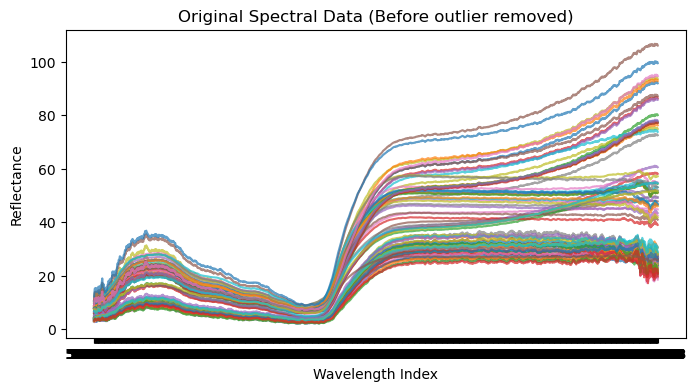

In [3]:
# Plot original spectral data (before preprocessing)
plt.figure(figsize=(8, 4))
plt.plot(X.T, alpha=0.7)
plt.title('Original Spectral Data (Before outlier removed)')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()

In [4]:
# Step 1: Calculate Q1, Q3, and IQR for the spectral data
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Step 2: Identify outliers in the spectral data
outliers = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

# Step 3: Create a mask to identify rows with any outliers
outlier_mask = outliers.any(axis=1)

# Step 4: Calculate the absolute deviation from the IQR boundaries for ranking
deviation = np.maximum((Q1 - X).abs(), (X - Q3).abs())

# Apply the mask to get deviations only for the identified outliers
deviation = deviation[outlier_mask]

# Step 5: Sum deviations across features for each sample (to rank overall extremeness)
total_deviation = deviation.sum(axis=1)

# Step 6: Calculate the maximum number of outliers to remove (5% of the total data)
num_samples = len(X)
max_outliers_to_remove = int(0.05 * num_samples)

# Get indices of the top 5% most extreme outliers
top_outlier_indices = total_deviation.nlargest(max_outliers_to_remove).index

# Create a new outlier mask based on the top 5% of deviations
final_outlier_mask = pd.Series(False, index=X.index)
final_outlier_mask.loc[top_outlier_indices] = True

# Step 7: Remove the top 5% most extreme outliers
cleaned_spectral_data = X[~final_outlier_mask]
cleaned_spad_data = y[~final_outlier_mask]

# Step 8: Combine the cleaned spectral data and SPAD values back into a single DataFrame (if needed)
cleaned_df = pd.concat([cleaned_spectral_data, cleaned_spad_data], axis=1)

# Step 9: Display the results
print(f"Original dataset size: {X.shape[0]}")
print(f"Number of outliers removed: {final_outlier_mask.sum()}")
print(f"Cleaned dataset size: {cleaned_df.shape[0]}")
print(f"Cleaned spectral data size: {cleaned_spectral_data.shape[0]}")

Original dataset size: 81
Number of outliers removed: 2
Cleaned dataset size: 79
Cleaned spectral data size: 79


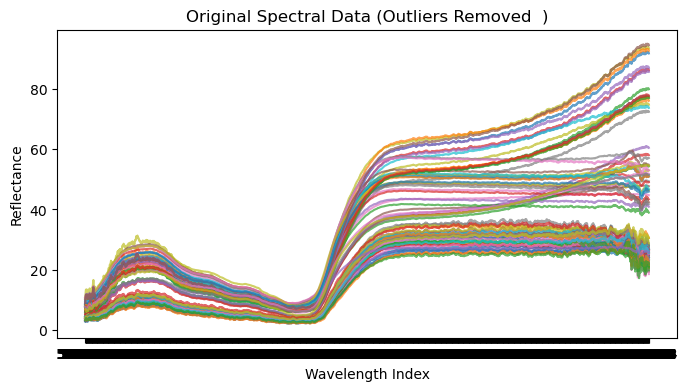

In [5]:
# Plot original spectral data (before preprocessing)
plt.figure(figsize=(8, 4))
plt.plot(cleaned_spectral_data.T,alpha=0.7)
plt.title('Original Spectral Data (Outliers Removed  )')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()

Correlation values with SPAD:
500.075   -0.821906
500.336   -0.776405
500.597   -0.714352
500.858   -0.687472
501.119   -0.725168
             ...   
949.809   -0.493087
950.048   -0.497321
950.286   -0.496810
950.524   -0.496881
950.763   -0.505108
Name: SPAD, Length: 1792, dtype: float64
Top features correlated with SPAD:
695.197    0.896281
695.451    0.896212
694.943    0.895481
695.706    0.895326
696.214    0.894935
693.925    0.894718
696.468    0.894577
694.688    0.894552
693.671    0.894536
694.434    0.894406
Name: SPAD, dtype: float64


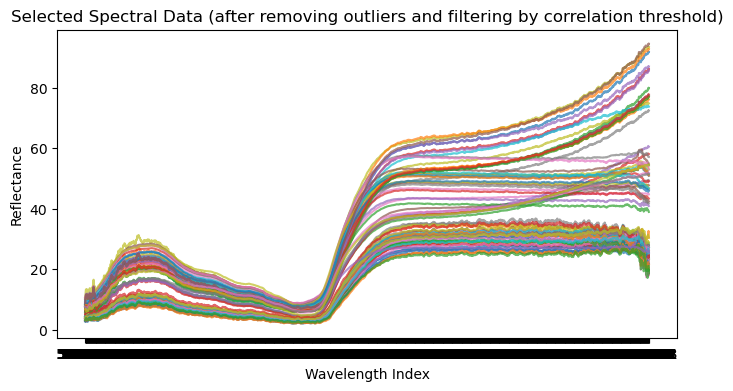

In [6]:
# Step 2: Calculate the correlation matrix for the combined DataFrame
correlation_matrix = cleaned_df.corr()

# Step 3: Extract correlations with the SPAD column (assuming the SPAD column is named 'SPAD')
correlations_with_spad = correlation_matrix['SPAD'].drop('SPAD')

# Step 4: Display the correlation values
print("Correlation values with SPAD:")
print(correlations_with_spad)

# Step 5: Sort correlations by absolute value to find strongest relationships
sorted_correlations = correlations_with_spad.abs().sort_values(ascending=False)
print("Top features correlated with SPAD:")
print(sorted_correlations.head(10))

# Step 6: Set a correlation threshold for feature selection
threshold = 0.5
mask = correlations_with_spad.abs() > threshold

# Step 7: Select features with a correlation higher than the threshold
selected_features = correlations_with_spad[mask].index
X_selected = cleaned_spectral_data[selected_features]

# Step 8: Plot the selected features from the cleaned spectral data
plt.figure(figsize=(8, 4))
plt.plot(X_selected.T, alpha=0.7)
plt.title('Selected Spectral Data (after removing outliers and filtering by correlation threshold)')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()


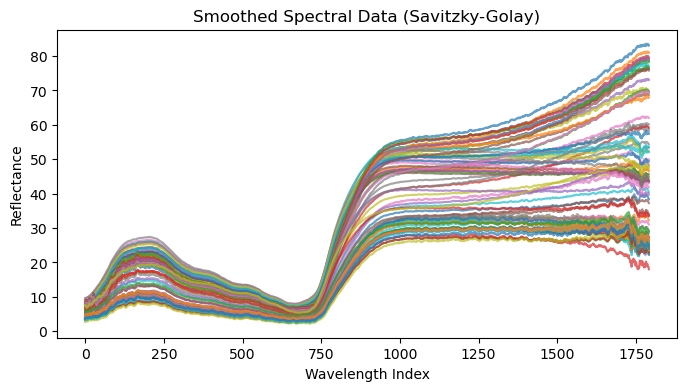

In [7]:
# Function to apply Savitzky-Golay smoothing
def savitzky_golay(cleaned_spectral_data, window_size=11, poly_order=2):
    return savgol_filter(cleaned_spectral_data, window_size, poly_order, axis=0)

# Apply Savitzky-Golay smoothing to X_selected
spectral_sgm = savitzky_golay(cleaned_spectral_data, window_size=11, poly_order=2)

#Plot the smoothed spectral data
plt.figure(figsize=(8, 4))
plt.plot(spectral_sgm.T, alpha=0.7)  # Transpose for better plotting
plt.title('Smoothed Spectral Data (Savitzky-Golay)')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()

In [8]:
#. Normalization and standardization
# Normalize spectral data
#normalizer = MinMaxScaler()
#spectral_normalized = normalizer.fit_transform(spectral_sgm)

#from sklearn.preprocessing import StandardScaler
# Then standardize
#scaler = StandardScaler()
#spectral_standardized = scaler.fit_transform(spectral_sgm)


In [9]:
# Apply PCA to determine the number of components to retain 95% variance
#pca = PCA()
#X_train_pca = pca.fit_transform(spectral_sgm)
#X_test_pca = pca.transform(spectral_sgm)
#explained_variance_ratio = pca.explained_variance_ratio_
#cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Scree plot
#plt.figure(figsize=(8, 4))
#plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual explained variance')
#plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', label='Cumulative explained variance')
#plt.xlabel('Number of Principal Components')
#plt.ylabel('Explained Variance Ratio')
#plt.legend()
#plt.title('Scree Plot')
#plt.grid(True)
#plt.show()

# Choose number of components to retain 95% variance
#n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
#print(f"Number of components to retain 95% variance: {n_components}")

In [10]:
#from sklearn.decomposition import FastICA
from sklearn.decomposition import FastICA
#Assume spectral_sgm is your input data after preprocessing
ica = FastICA(n_components=5, max_iter=500, tol=0.01, random_state=175)

# Apply ICA to the spectral data
X_ica = ica.fit_transform(spectral_sgm)

# Check the shape of the transformed data
print(f"Shape of ICA-transformed data: {X_ica.shape}")


Shape of ICA-transformed data: (79, 5)


In [11]:
# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ica,cleaned_spad_data, test_size=0.20, random_state=175)

In [12]:
import pandas as pd
import numpy as np


# Custom CFS-like feature selection function
def cfs_feature_selection(X_train, y_train, target_corr_threshold=0.5, feature_corr_threshold=0.5):
    # Calculate correlation matrix
    correlation_matrix = pd.DataFrame(X_train).corr()

    # Calculate correlations with the target (y)
    target_correlations = np.array([np.corrcoef(X_train[:, i], y_train)[0, 1] for i in range(X_train.shape[1])])

    # Step 1: Select features based on their correlation with the target
    selected_features = np.where(np.abs(target_correlations) >= target_corr_threshold)[0]

    # Step 2: Remove highly correlated features among themselves
    # Check correlations among the selected features
    filtered_features = []
    
    for feature_idx in selected_features:
        add_feature = True
        for filtered_idx in filtered_features:
            if np.abs(correlation_matrix.iloc[feature_idx, filtered_idx]) >= feature_corr_threshold:
                add_feature = False
                break
        if add_feature:
            filtered_features.append(feature_idx)
    
    # Return filtered features and their indices
    return X_train[:, filtered_features], filtered_features

# Apply CFS-like feature selection
X_train_cfs, selected_features = cfs_feature_selection(X_train, y_train, target_corr_threshold=0.5, feature_corr_threshold=0.8)

# Transform X_test using selected features from X_train
X_test_cfs = X_test[:, selected_features]

# Display the selected features
print(f"Number of features selected by CFS: {len(selected_features)}")
print("Selected feature indices (CFS):", selected_features)


Number of features selected by CFS: 1
Selected feature indices (CFS): [4]


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

# Parameter grid for RandomizedSearchCV
n_estimators = np.arange(50, 900, 5)
max_depth = np.arange(1, 101, 1)
min_samples_split = np.arange(2, 111, 1)
min_samples_leaf = np.arange(2, 111, 1)
min_impurity_decrease = np.linspace(0, 0.1, 1)
# Adding max_features and min_impurity_decrease to help control complexity
param_dist_rf = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'min_impurity_decrease': min_impurity_decrease,  # Helps reduce overfitting
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2']
   
}

# Initialize model
model_rf = RandomForestRegressor(random_state=175)

# Perform RandomizedSearchCV
random_search_rf = RandomizedSearchCV(model_rf, 
    param_distributions=param_dist_rf, n_iter=200,  # Increase iterations for better search
    cv=10,  # Increase cross-validation folds
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    random_state=175, 
    error_score='raise'
)

# Fit RandomizedSearchCV to find the best hyperparameters
random_search_rf.fit(X_train_cfs, y_train)
best_rf = random_search_rf.best_estimator_
best_params_rf = random_search_rf.best_params_
print("Best parameters for Random Forest: ", best_params_rf)

# Cross-validation with the best hyperparameters
mse_scores_rf = cross_val_score(best_rf, X_train_cfs, y_train, scoring='neg_mean_squared_error', cv=10)
mse_scores_rf = -mse_scores_rf  # Convert negative MSE to positive
average_mse_rf = np.mean(mse_scores_rf)

# Print cross-validation results
print(f"Average MSE for Random Forest: {average_mse_rf}")

# Evaluate models
models = {"RandomForest": best_rf}

# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_cfs, y_train)
    
    y_train_pred = model.predict(X_train_cfs)
    y_test_pred = model.predict(X_test_cfs)
    
    if y_train_pred.ndim > 1:  # Ensure correct shape for predictions
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    # Metrics for train data
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    # Metrics for test data
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

# Print evaluation metrics
print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)

print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for Random Forest:  {'n_estimators': 515, 'min_samples_split': 24, 'min_samples_leaf': 26, 'min_impurity_decrease': 0.0, 'max_features': 'log2', 'max_depth': 76, 'bootstrap': False}
Average MSE for Random Forest: 9.071795622137426
Evaluating RandomForest model...
Training Metrics:
                   MAE     MSE  Pearson        R2      RMSE       RPD
RandomForest  2.247144  8.4281   0.8688  0.754813  2.903119  2.019533

Testing Metrics:
                   MAE       MSE   Pearson        R2     RMSE       RPD
RandomForest  2.492743  8.523308  0.895385  0.738593  2.91947  1.955876


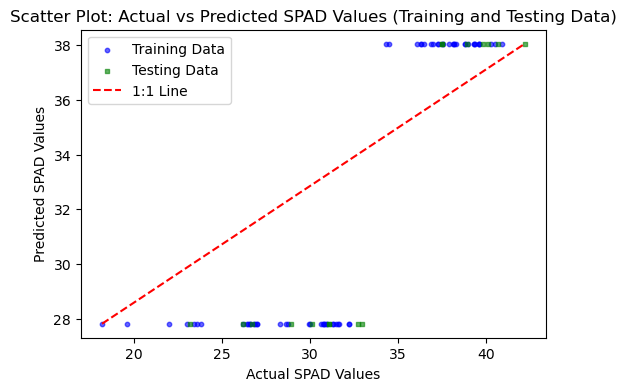

In [14]:
import matplotlib.pyplot as plt

# Assuming these are your actual and predicted SPAD values for both training and testing sets
y_train_actual = y_train # Replace with your actual training SPAD values
y_train_predicted = y_train_pred # Replace with your predicted SPAD values from the model (training)

y_test_actual = y_test  # Replace with your actual testing SPAD values
y_test_predicted = y_test_pred  # Replace with your predicted SPAD values from the model (testing)

# Combined Plot
plt.figure(figsize=(6, 4))

# Scatter plot for Training Data (circles)
plt.scatter(y_train_actual, y_train_predicted, color='blue', alpha=0.6, s=10, marker='o', label='Training Data')

# Scatter plot for Testing Data (squares)
plt.scatter(y_test_actual, y_test_predicted, color='green', alpha=0.6, s=10, marker='s', label='Testing Data')

# Plot the 1:1 line (perfect prediction)
plt.plot([min(min(y_train_actual), min(y_test_actual)), max(max(y_train_actual), max(y_test_actual))],
         [min(min(y_train_predicted), min(y_test_predicted)), max(max(y_train_predicted), max(y_test_predicted))],
         color='red', linestyle='--', label='1:1 Line')

# Labels and title
plt.xlabel('Actual SPAD Values', fontsize=10)
plt.ylabel('Predicted SPAD Values', fontsize=10)
plt.title('Scatter Plot: Actual vs Predicted SPAD Values (Training and Testing Data)', fontsize=12)

# Add legend
plt.legend()

# Remove grid and display plot
plt.show()

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from xgboost import XGBRegressor

# Define parameter grids for RandomizedSearchCV
n_estimators = np.arange(20, 100, 5)
learning_rate = np.arange(0.01, 1, 0.1)
max_depth = np.arange(2, 50, 1)
subsample = np.arange(0.6, 1.0, 0.05) 
colsample_bytree = np.arange(0.6, 1.0, 0.05)

# Additional hyperparameters to help control model complexity
gamma = np.arange(0, 0.5, 0.05)  # Regularization term to reduce overfitting
reg_lambda = np.arange(0, 1.0, 0.05)  # L2 regularization
reg_alpha = np.arange(0, 1.0, 0.05)  # L1 regularization

param_dist_xgb = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    'gamma': gamma,  # Regularization parameters
    'reg_lambda': reg_lambda,
    'reg_alpha': reg_alpha
}

# Initialize model
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=200)

# Perform RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    model_xgb, 
    param_distributions=param_dist_xgb, 
    n_iter=300,  # Increase if you have more computation power for better search
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    random_state=175, 
    error_score='raise'
)

# Fit RandomizedSearchCV to find the best hyperparameters
random_search_xgb.fit(X_train_cfs, y_train)
best_xgb = random_search_xgb.best_estimator_
best_params_xgb = random_search_xgb.best_params_
print("Best parameters for XGBoost: ", best_params_xgb)

# Cross-validation with the best hyperparameters
mse_scores_xgb = cross_val_score(best_xgb, X_train_cfs, y_train, scoring='neg_mean_squared_error', cv=5)
mse_scores_xgb = -mse_scores_xgb  # Convert negative MSE to positive
average_mse_xgb = np.mean(mse_scores_xgb)

# Print cross-validation results
print(f"Average MSE for XGBoost: {average_mse_xgb}")

# Evaluate the individual models
models = {"XGBoost": best_xgb}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_cfs, y_train)
    
    y_train_pred = model.predict(X_train_cfs)
    y_test_pred = model.predict(X_test_cfs)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

# Print evaluation metrics
print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)

print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for XGBoost:  {'subsample': 0.65, 'reg_lambda': 0.65, 'reg_alpha': 0.9, 'n_estimators': 30, 'max_depth': 33, 'learning_rate': 0.11, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.7500000000000001}
Average MSE for XGBoost: 12.416398022278681
Evaluating XGBoost model...
Training Metrics:
              MAE       MSE   Pearson        R2      RMSE       RPD
XGBoost  1.217991  2.602999  0.968294  0.924274  1.613381  3.633949

Testing Metrics:
              MAE        MSE   Pearson        R2      RMSE       RPD
XGBoost  2.623753  15.070303  0.777516  0.537799  3.882049  1.470904


In [25]:
from scipy.stats import pearsonr

# Define parameter grids for RandomizedSearchCV
n_estimators = np.arange(2, 30, 5)
learning_rate = np.arange(0.01, 1, 0.1)
max_depth = np.arange(2, 50, 3)

param_dist_gb = {
   'n_estimators': n_estimators,
   'learning_rate': learning_rate,
   'max_depth': max_depth
}

# Initialize models
model_gb = GradientBoostingRegressor(random_state=175)

# Perform RandomizedSearchCV for each model
random_search_gb = RandomizedSearchCV(model_gb, param_distributions=param_dist_gb, n_iter=32, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_gb.fit(X_train_cfs, y_train)
best_gb = random_search_gb.best_estimator_
best_params_gb = random_search_gb.best_params_
print("Best parameters for Gradient Boosting: ", best_params_gb)

# Cross-validation with the best hyperparameters for each model
mse_scores_gb = cross_val_score(best_gb, X_train_cfs, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_gb = -mse_scores_gb
average_mse_gb = np.mean(mse_scores_gb)
# Print cross-validation results
print(f"Average MSE for Gradient Boosting: {average_mse_gb}")

# Evaluate the individual models
models = {
    "GradientBoosting": best_gb
}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_cfs, y_train)
    
    y_train_pred = model.predict(X_train_cfs)
    y_test_pred = model.predict(X_test_cfs)
    
    # Calculate metrics for training and test datasets
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for Gradient Boosting:  {'n_estimators': 7, 'max_depth': 2, 'learning_rate': 0.6100000000000001}
Average MSE for Gradient Boosting: 10.168327014387849
Evaluating GradientBoosting model...
Training Metrics:
                       MAE       MSE  Pearson        R2      RMSE       RPD
GradientBoosting  1.337912  2.493045  0.96495  0.927473  1.578938  3.713221

Testing Metrics:
                       MAE        MSE   Pearson        R2      RMSE       RPD
GradientBoosting  2.829899  12.768227  0.828512  0.608403  3.573266  1.598012


In [17]:
from scipy.stats import pearsonr

# Define parameter grids for RandomizedSearchCV
C = np.arange(0.1, 1, 0.2)
epsilon = np.arange(1, 50, 2)

param_dist_svr = {
    'C': C,
    'epsilon': epsilon,
    'kernel': ['linear', 'rbf']
}

# Initialize models
model_svr = SVR()

# Perform RandomizedSearchCV for SVR
random_search_svr = RandomizedSearchCV(model_svr, param_distributions=param_dist_svr, n_iter=32, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_svr.fit(X_train_cfs, y_train)
best_svr = random_search_svr.best_estimator_
best_params_svr = random_search_svr.best_params_
print("Best parameters for SVR: ", best_params_svr)

# Cross-validation with the best hyperparameters
mse_scores_svr = cross_val_score(best_svr, X_train_cfs, y_train, scoring='neg_mean_squared_error', cv=5)
mse_scores_svr = -mse_scores_svr  # Convert negative MSE to positive
average_mse_svr = np.mean(mse_scores_svr)
print(f"Average MSE for SVR: {average_mse_svr}")

# Evaluate the individual models
models = {
    "SVR": best_svr
}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_cfs, y_train)
    
    y_train_pred = model.predict(X_train_cfs)
    y_test_pred = model.predict(X_test_cfs)
    
    # Ensure predictions have the correct shape
    if y_train_pred.ndim > 1:
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for SVR:  {'kernel': 'rbf', 'epsilon': 1, 'C': 0.9000000000000001}
Average MSE for SVR: 10.845657887376289
Evaluating SVR model...
Training Metrics:
          MAE       MSE   Pearson        R2      RMSE       RPD
SVR  2.281487  9.408409  0.864654  0.726294  3.067313  1.911427

Testing Metrics:
          MAE        MSE   Pearson        R2      RMSE       RPD
SVR  2.808487  11.033831  0.853801  0.661596  3.321721  1.719025


In [18]:
# Define parameter grids for RandomizedSearchCV
param_dist_elnet = {
    'alpha': [0.05, 0.1, 1, 10, 100],
    'l1_ratio': [0.05, 0.1, 0.2, 0.9,1]
}
# Initialize models
model_elnet = ElasticNet(random_state=175) 
# Perform RandomizedSearchCV for each model
random_search_elnet = RandomizedSearchCV(model_elnet, param_distributions=param_dist_elnet, n_iter=25, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_elnet.fit(X_train_cfs, y_train)
best_elnet = random_search_elnet.best_estimator_
best_params_elnet = random_search_elnet.best_params_
print("Best parameters for Elastic Net: ", best_params_elnet)
# Cross-validation with the best hyperparameters for each model
mse_scores_elnet = cross_val_score(best_elnet, X_train_cfs, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_elnet = -mse_scores_elnet
average_mse_elnet = np.mean(mse_scores_elnet)
# Print cross-validation results
print(f"Average MSE for Elastic Net: {average_mse_elnet}")
# Evaluate the individual models
models = {
    "ElasticNet": best_elnet
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_cfs, y_train)
    
    y_train_pred = model.predict(X_train_cfs)
    y_test_pred = model.predict(X_test_cfs)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Best parameters for Elastic Net:  {'l1_ratio': 1, 'alpha': 0.05}
Average MSE for Elastic Net: 10.240069562357501
Evaluating ElasticNet model...
Training Metrics:
                 MAE       MSE  Pearson       R2      RMSE       RPD
ElasticNet  2.400852  9.884968  0.84737  0.71243  3.144037  1.864783

Testing Metrics:
                 MAE        MSE   Pearson        R2      RMSE      RPD
ElasticNet  3.141882  14.107112  0.800977  0.567339  3.755944  1.52029


In [19]:
# Define parameter grids for RandomizedSearchCV

# Initialize models
model_plsr = PLSRegression(n_components=1) 

# Perform RandomizedSearchCV for each model
# PLSR does not require hyperparameter tuning here
best_plsr = model_plsr
best_plsr.fit(X_train_cfs, y_train)
# Cross-validation with the best hyperparameters for each model

mse_scores_plsr = cross_val_score(best_plsr, X_train_cfs, y_train, scoring='neg_mean_squared_error', cv=3)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_plsr = -mse_scores_plsr
average_mse_plsr = np.mean(mse_scores_plsr)
# Print cross-validation results
print(f"Average MSE for PLSR: {average_mse_plsr}")
# Evaluate the individual models
models = {
    "PLSR": best_plsr
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_cfs, y_train)
    
    y_train_pred = model.predict(X_train_cfs)
    y_test_pred = model.predict(X_test_cfs)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Average MSE for PLSR: 10.10790552985786
Evaluating PLSR model...
Training Metrics:
           MAE       MSE  Pearson        R2      RMSE       RPD
PLSR  2.347105  9.692289  0.84737  0.718035  3.113244  1.883227

Testing Metrics:
           MAE        MSE   Pearson        R2     RMSE       RPD
PLSR  3.177572  14.094618  0.800977  0.567723  3.75428  1.520963


In [20]:
# Ensemble the models using Voting Regressor
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('gb', best_gb),
    ('svr', best_svr),
    ('elnet', best_elnet)
])

ensemble_model.fit(X_train_cfs, y_train)
y_ensemble_pred = ensemble_model.predict(X_test_cfs)

# Evaluate the ensemble model
ensemble_metrics_train = calculate_metrics(y_train, ensemble_model.predict(X_train_cfs))
ensemble_metrics_test = calculate_metrics(y_test, y_ensemble_pred)
print("\nEnsemble Model Training Metrics:")
print(pd.DataFrame(ensemble_metrics_train, index=["Ensemble"]).T)
print("\nEnsemble Model Testing Metrics:")
print(pd.DataFrame(ensemble_metrics_test, index=["Ensemble"]).T)


Ensemble Model Training Metrics:
         Ensemble
MSE      4.287291
RMSE     2.070577
MAE      1.541974
R2       0.875276
RPD      2.831551
Pearson  0.944848

Ensemble Model Testing Metrics:
          Ensemble
MSE      10.754415
RMSE      3.279393
MAE       2.536743
R2        0.670166
RPD       1.741213
Pearson   0.858720


In [21]:
# Ensemble the models using Voting Regressor # 2 the best model ensembled
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb)
])

ensemble_model.fit(X_train_cfs, y_train)
y_ensemble_pred = ensemble_model.predict(X_test_cfs)

# Evaluate the ensemble model
ensemble_metrics_train = calculate_metrics(y_train, ensemble_model.predict(X_train_cfs))
ensemble_metrics_test = calculate_metrics(y_test, y_ensemble_pred)
print("\nEnsemble Model Training Metrics:")
print(pd.DataFrame(ensemble_metrics_train, index=["Ensemble"]).T)
print("\nEnsemble Model Testing Metrics:")
print(pd.DataFrame(ensemble_metrics_test, index=["Ensemble"]).T)


Ensemble Model Training Metrics:
         Ensemble
MSE      4.690431
RMSE     2.165740
MAE      1.654242
R2       0.863548
RPD      2.707132
Pearson  0.933222

Ensemble Model Testing Metrics:
          Ensemble
MSE      10.131905
RMSE      3.183065
MAE       2.444392
R2        0.689258
RPD       1.793907
Pearson   0.871075
